# Extrapolating with a TS Model

This notebook is meant to explore the long-run behavior of fitted time series models when extrapolating into the future, or "forecasting". We distinguish a "fitted" model from the underlying statistical process where you are not introducing new noise and simply extrapolating the deterministic component of the model. The limiting behavior of the processes is related to whether it is stationary.

This notebook adds mathematical clarity to the other notebook on forecasting with an ARX.

In [1]:
# Set up environment
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_process import ArmaProcess
from ts_tools import sim_arma, plot_ts, plt_acf

## Pure MA Process

### Stationarity

The pure MA processes with a constant mean is **always stationary**. An MA(q) processes is defined as:

$$
z_t = \mu+ \sum_{i=0}^q\theta_i\epsilon_{t-i}, \quad\epsilon_t \overset{\text{i.i.d.}}{\sim}  N(0,\sigma^2)
$$

Where $\theta_0 = 1$, we define it in one sum to make the autocovariance derivation easier. 

The expected value and variance are constant for the process:

$$
E[z_t] = \mu
$$

$$
\begin{align*}
Var[z_t] &= Var[\mu] + \sum_{i=0}^q Var[\theta_i\epsilon_{t-i}] \\
&= \sigma^2 \sum_{i=0}^q \theta_i^2 \\
&= \sigma^2(1+\sum_{i=1}^q \theta_i^2)
\end{align*}
$$

The autocovariance function is a bit tedious to derive, as it involves lining up the indices of the coefficient terms for appropriate lags. The ACF ends up as a function of lag $k$, not of time:

$$
\begin{align*}
Cov[z_t, z_{t-k}] &= Cov\left[\mu+ \sum_{i=1}^q\theta_i\epsilon_{t-i} +\epsilon_t, \mu+ \sum_{i=1}^q\theta_i\epsilon_{t-i-k} +\epsilon_{t-k}\right] \\ 
&= 
\begin{cases} 
    \sigma^2\sum_{i=0}^q \theta_i\theta_{i-k} &\text{ for } 0\leq k \leq q \\
    0 &\text{ for } k > q
\end{cases}
\end{align*}
$$

These properties combine to show weak stationarity (it's also strong stationary)

### Extrapolation with Fitted MA Model

We describe the behavior of a MA(1) model. The general MA(q) extends these concepts straightforwardly. Consider an MA(1) model:

$$
y_t = \mu + \theta\epsilon_{t-1}+\epsilon_t
$$

We estimate the coefficients with sample time series $y_1, \dots, y_N$. We wish to extrapolate the model forward without introducing new noise. The estimated extrapolated value one time step in the future is generated using the residual from the previous time step. The current $\epsilon_t$ value is set to zero:

$$
\begin{align*}
\hat y_{N+1} &= \hat \mu + \hat \theta \hat \epsilon_{t-1} \\
&= \hat \mu + \hat\theta (y_N - \hat y_N)
\end{align*}
$$

So we can use the residual calculated by comparing the fitted values of the model to the observed values. For the next forecasted value, we have:

$$
\begin{align*}
\hat y_{N+2} &= \hat \mu + \hat\theta \hat \epsilon_{N+1}\\
&= \hat \mu
\end{align*}
$$

But we assumed that we generated $y_{N+1}$ with zero additional noise, so the modeling error at $N+1$ is assumed to be zero. Thus, after 1 time step into the future, all of the forecasts decay to the estimated mean $\hat \mu$. For a general MA(q) process, the forecasts decay to the estimated mean after $q$ steps.

### Simulations

We simulate a mean-zero MA(3) process with known coefficients, then fit a model to estimate the coefficients, and finally extrapolate/forecast the model into the future. 

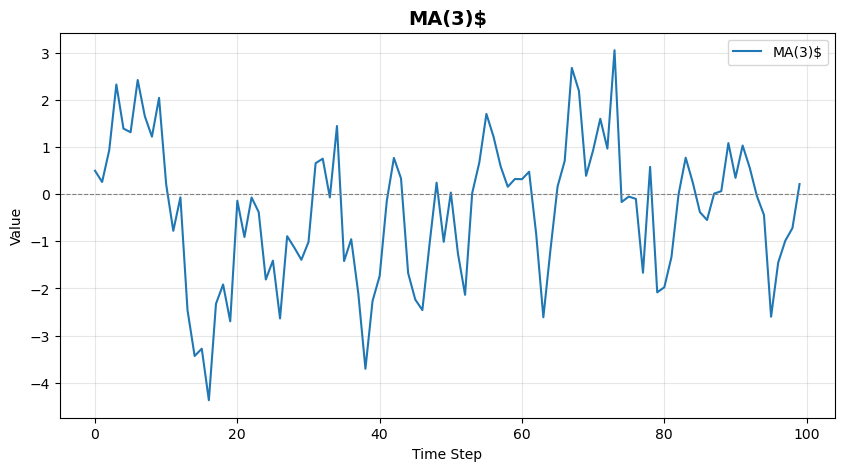

In [9]:
np.random.seed(123)
Nt = 100 
z = sim_arma(n=Nt, ma_coefs = [1, 0.8, 0.8, 0.8])
plot_ts(z, title="MA(3)$")

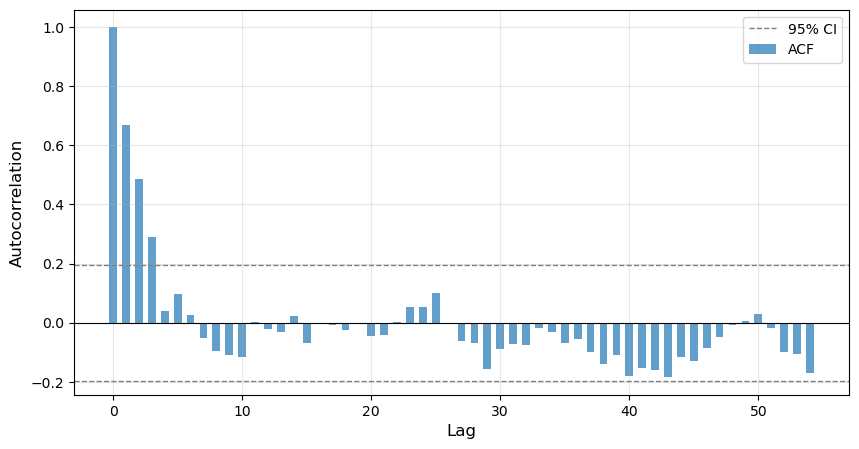

In [7]:
plt_acf(z)

In [8]:
ma3 = ARIMA(z, order=(0, 0, 3)).fit() # MA(1)
ma3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.3462,0.355,-0.975,0.330,-1.042,0.350
ma.L1,0.8762,0.057,15.498,0.000,0.765,0.987
ma.L2,0.8980,0.073,12.343,0.000,0.755,1.041
ma.L3,0.9260,0.067,13.866,0.000,0.795,1.057
sigma2,0.7634,0.112,6.827,0.000,0.544,0.983


The ACF plot shows 3 significant non-zero lags, as expected. The fitted model coefficients are relatively close to the target values. The estimated mean is the value that the extrapolated series will converge to. When forecasting, the values decay to the mean of zero after 3 time steps

Text(100, 2, 'Forecast Start')

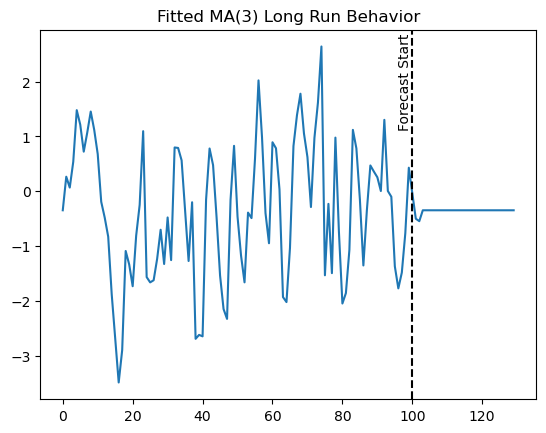

In [12]:
Nf = 30
fits = ma3.fittedvalues
preds = ma3.forecast(steps=Nf)

plt.title("Fitted MA(3) Long Run Behavior")
plt.plot(np.concatenate([fits, preds]))
plt.axvline(x = Nt, linestyle="dashed", color="k")
plt.text(Nt, 2, 'Forecast Start', rotation=90,
         verticalalignment='center', horizontalalignment='right',
         color='k')

Text(0.5, 0.98, 'Fitted MA(3) Long Run Behavior')

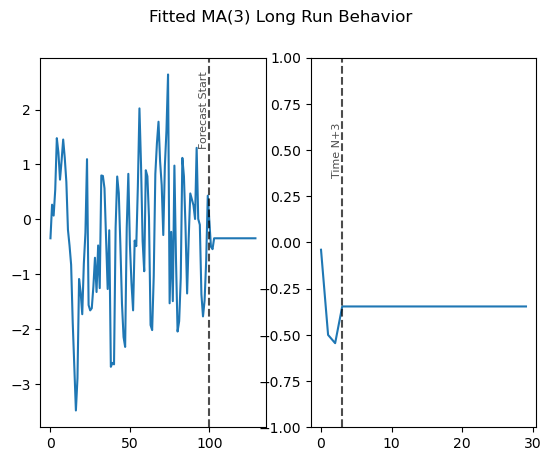

In [23]:
Nf = 30
fits = ma3.fittedvalues
preds = ma3.forecast(steps=Nf)

fig, axs = plt.subplots(1, 2)


axs[0].plot(np.concatenate([fits, preds]))
axs[0].axvline(x = Nt, linestyle="dashed", color="k", alpha=.7)
axs[0].text(Nt, 2, 'Forecast Start', rotation=90,
         verticalalignment='center', horizontalalignment='right',
         color='k', fontsize=8, alpha=.7)

axs[1].plot(np.concatenate([preds]))
axs[1].set_ylim(-1, 1)
axs[1].axvline(x = 3, linestyle="dashed", color="k", alpha=.7)
axs[1].text(3, 0.5, 'Time N+3', rotation=90,
         verticalalignment='center', horizontalalignment='right',
         color='k', fontsize=8, alpha=.7)


fig.suptitle("Fitted MA(3) Long Run Behavior")

## Pure AR Models

Autoregressive models can have 3 types of long range behavior when forecasted into the future with no new sources of noise:

1. Converge to a finite value (weakly stationary)
2. Diverge to +/- infinity, or oscillate to those extremes
3. A Random Gaussian Walk

These behaviors can be shown when examining the mean of the processes.

### Stationarity

We consider an AR(1) processes, but the concept extends to general AR(p) processes straightforwardly. The AR(1) process is defined as:

$$
y_t = \mu + \gamma y_{t-1} + \epsilon_t, \quad\epsilon_t \overset{\text{i.i.d.}}{\sim}  N(0,\sigma^2)
$$

The theoretical mean is found by analyzing the infinite sum and applying the convergence rules for geometric series:

$$
\begin{align*}
    E[y_t] &= E[\mu + \gamma y_{t-1}+\epsilon_t] \\ 
    &= 
\end{align*}
$$

### Case 1: Stationary Process Converges to Equilibrium

In [ ]:
np.random.seed(123)
Nt = 100 
z = sim_arma(n=Nt, ar_coefs = [1, 0.8])
plot_ts(z, title="AR(1), $y_t = -0.8y_{t-1}$")

In [ ]:
plt_acf(z)

In [ ]:
ar1 = ARIMA(z, order=(1, 0, 0)).fit() # AR(1)
ar1.summary().tables[1]

In [ ]:
Nf = 30
t2 = np.arange(Nt, Nt+Nf) # Forecast times added to sim times
fits = ar1.fittedvalues
preds = ar1.forecast(steps=Nf)

In [ ]:
plt.title("Fitted AR(1) Long Run Behavior,  $y_t = -0.8y_{t-1}$")
plt.plot(np.concatenate([fits, preds]))
plt.axvline(x = Nt, linestyle="dashed", color="k")
plt.text(Nt, 2.5, 'Forecast Start', rotation=90,
         verticalalignment='center', horizontalalignment='right',
         color='k')